In [1]:
#Date 27/ 03/ 2021
#We are going to do is first EPR sharing and then the shaired pair measurement by a third party

In [2]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plotter
import numpy as np
from IPython.display import display, Math, Latex
%matplotlib inline

In [3]:
#number of pair of epr pairs each have
num_pair = 4

#here alice_epr and bob_epr are a random array of 0 and 1
#0 means that pair should be made |psi+> and 1 means |pis->
alice_epr = np.random.randint(2, size = num_pair)
bob_epr = np.random.randint(2, size = num_pair)

alice_qubits = QuantumRegister(2*num_pair, 'alice')
bob_qubits = QuantumRegister(2*num_pair, 'bob')
charlie = ClassicalRegister(2*num_pair, 'charlie')

In [4]:
#here this is the function to encode qubit indexed a and b of circuit in psi_plus or psi_minus respectively

def encode_psi_plus(circuit, a, b):
    circuit.h(a)
    circuit.x(b)
    circuit.cx(a, b)
    return circuit

def encode_psi_minus(circuit, a, b):
    circuit.x([a,b])
    circuit.h(a)
    circuit.cx(a, b)
    return circuit

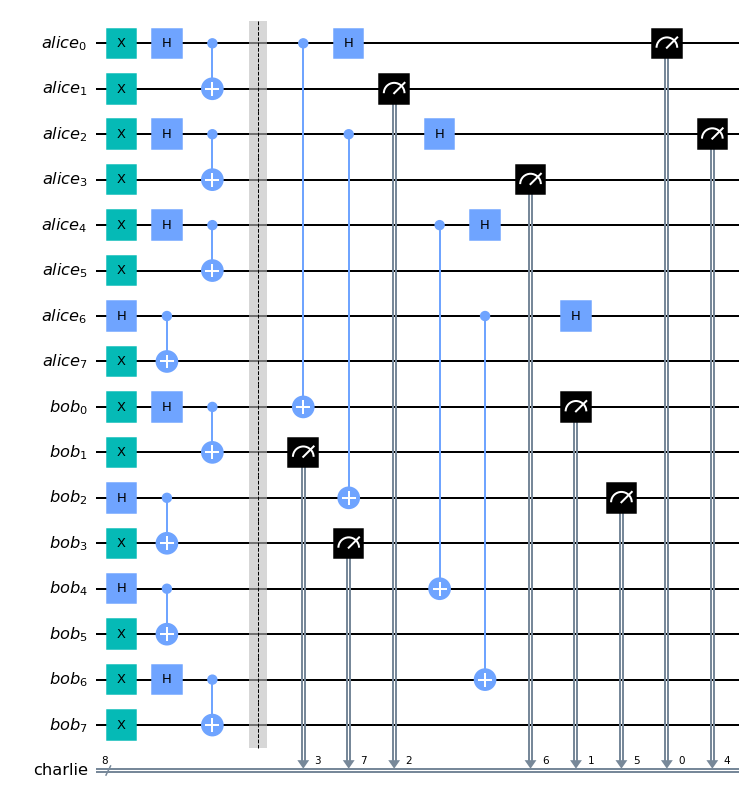

In [5]:
circuit = QuantumCircuit(alice_qubits, bob_qubits, charlie)

for i in range(0, 2*num_pair, 2): 
    j = i//2
    #print(j)
    if alice_epr[j] == 0:
        circuit = encode_psi_plus(circuit, alice_qubits[i], alice_qubits[i+1])
    elif alice_epr[j] == 1:
        circuit = encode_psi_minus(circuit, alice_qubits[i], alice_qubits[i+1])
        
    if bob_epr[j] == 0:
        circuit = encode_psi_plus(circuit, bob_qubits[i], bob_qubits[i+1])
    elif bob_epr[j] == 1:
        circuit = encode_psi_minus(circuit, bob_qubits[i], bob_qubits[i+1])
    
# the EPR encoding is done now
circuit.barrier()

#now Charlie will measure one qubit from each pair from both of them
for i in range(0, 2*num_pair, 2):
    
    j = i//2
    #to measure in bell basis
    circuit.cx(alice_qubits[i], bob_qubits[i])
    circuit.h(alice_qubits[i])
    
    circuit.measure([alice_qubits[j], bob_qubits[j]], [i, i+1])
    
circuit.draw(output = 'mpl')

In [6]:
def run_circuit(qc2):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc2, backend, shots = 2000).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

def one_shot_result(qc):
    backend = Aer.get_backend('qasm_simulator') # we choose the simulator as our backend
    result = execute(qc, backend, shots = 1).result() # we run the simulation
    counts = result.get_counts() # we get the counts
    return counts

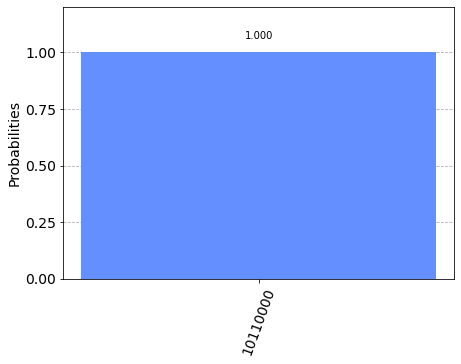

In [7]:
#here this is the result of one shot experiment 

counts = one_shot_result(circuit)
plot_histogram(counts)

In [8]:
r = counts.items()
for res, shots in r:
    result = str(res)

#these results are in simple Z basis

for i in range(num_pair):
    print("Result of pair " + str(i) + " of epr_pairs gave " + result[i] + " " + result[i+1])

Result of pair 0 of epr_pairs gave 1 0
Result of pair 1 of epr_pairs gave 0 1
Result of pair 2 of epr_pairs gave 1 1
Result of pair 3 of epr_pairs gave 1 0


In [9]:
##Message Encoding step

#now first generating a randomn message string
#bit lenght will be 2 for each qubit as we are going to use a kind of dense coding

message = np.random.randint(2, size = 2*num_pair)

#first convert all the senders qubit that is of alice into psi_minus by using sigma_z operation

circuit.barrier()

for i in range(num_pair, 2*num_pair):
    circuit.z(alice_qubits[i])

circuit.barrier()

#now all senders qubit are converted to psi_minus now we will Encode our message
print("The initial message is : " + str(message))

The initial message is : [1 0 1 1 1 1 0 1]


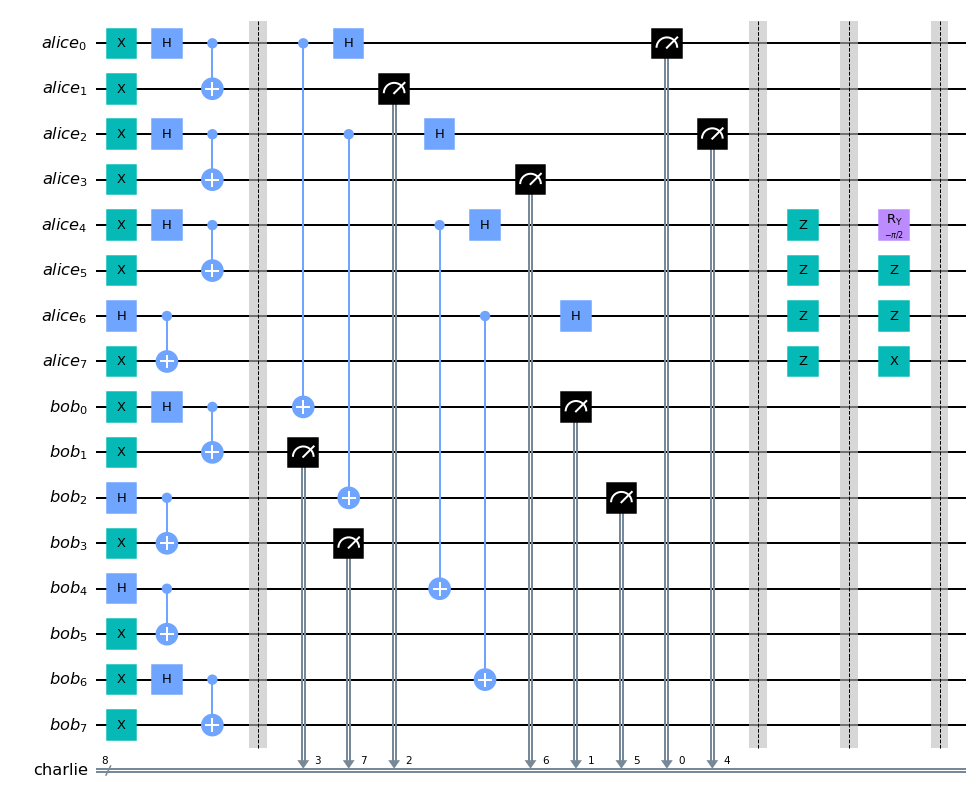

In [10]:
#now dense coding the qubits according to our message

#changes has to be done 

for i in range(0, 2*num_pair, 2):
    j = i//2
    if message[i] == 0 and message[i+1] == 0:
        continue
    elif message[i] == 0 and message[i+1] == 1:
        circuit.x(alice_qubits[num_pair + j])
    elif message[i] == 1 and message[i+1] == 0:
        circuit.ry(-np.pi/2, alice_qubits[num_pair + j])
    elif message[i] == 1 and message[i+1] == 1:
        circuit.z(alice_qubits[num_pair + j])

circuit.barrier()
circuit.draw(output = 'mpl')

#can be used for security check by randomly inserting sigma_z or I in bob qubits

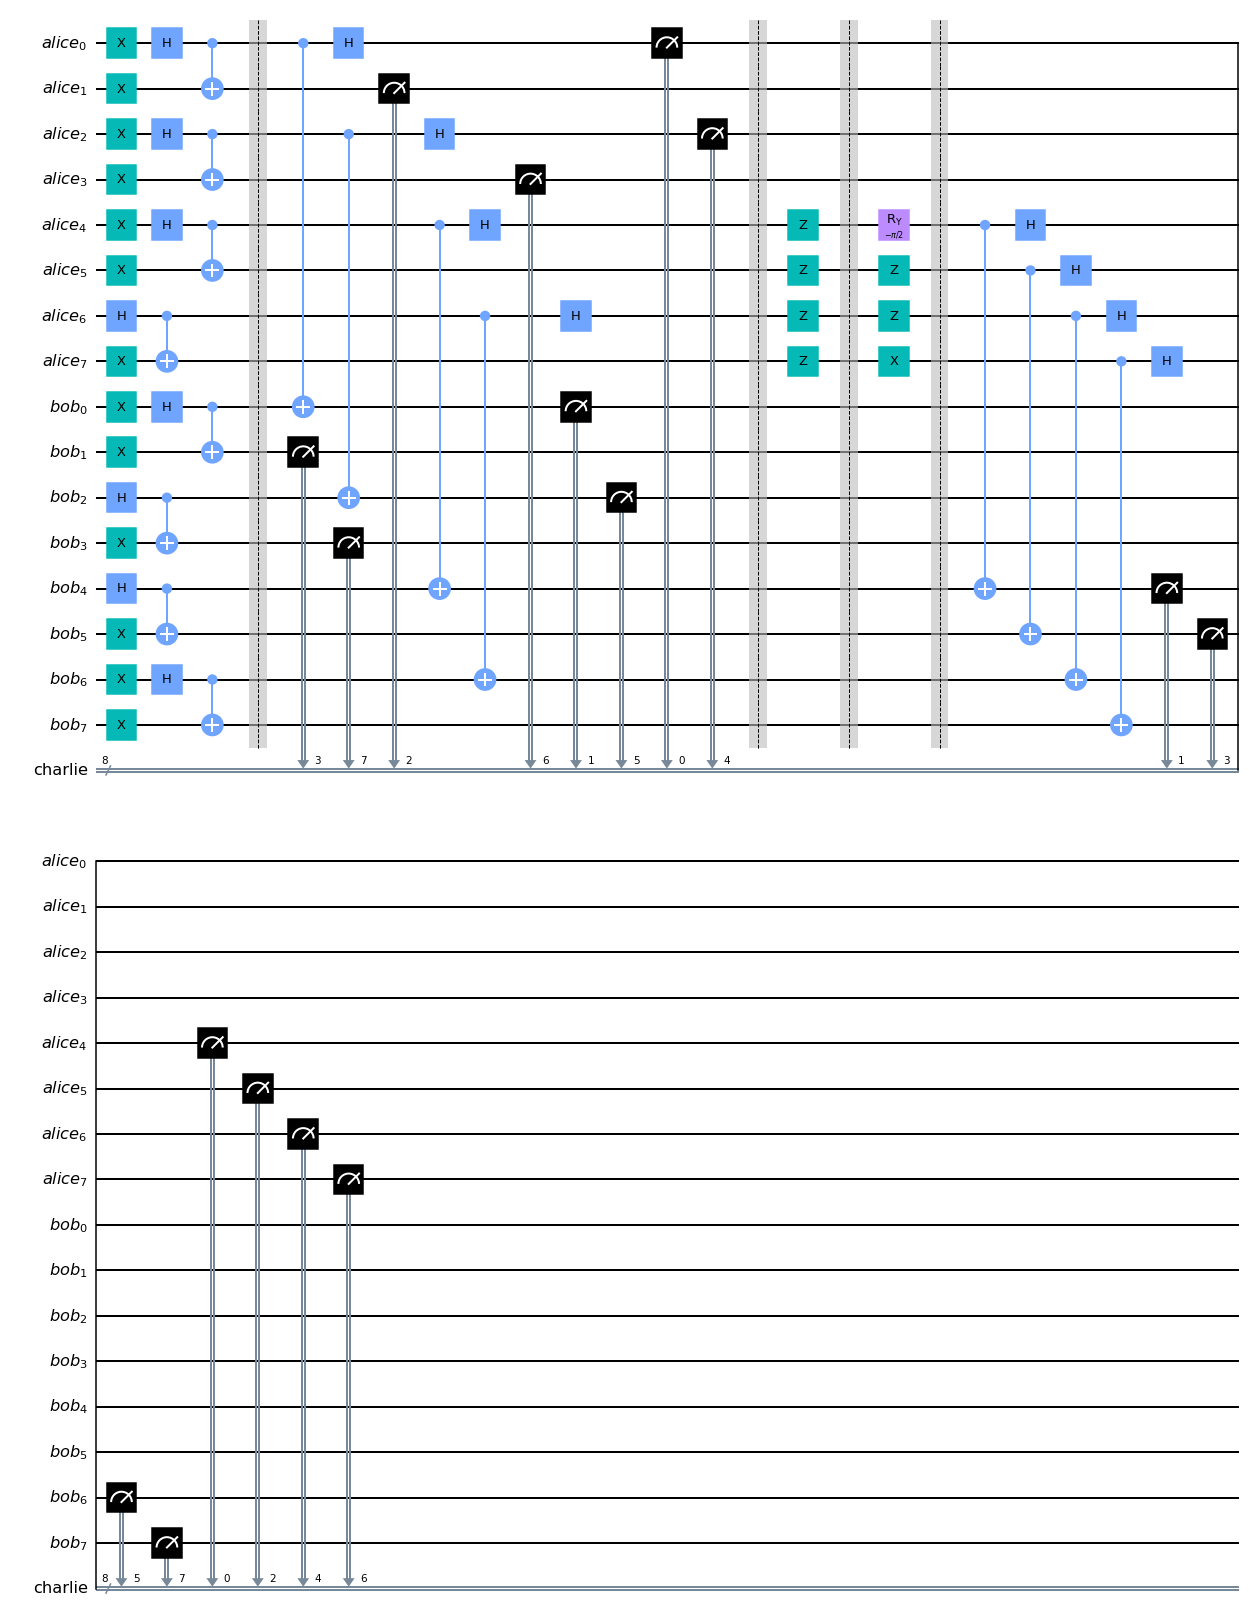

In [11]:
# now dense coding is done now the measurement part is done by a third person charlie to complete the MDI-QSDC protocol
j = 0
for i in range(num_pair, 2*num_pair):
    
    #using bell basis for measurement
    circuit.cx(alice_qubits[i], bob_qubits[i])
    circuit.h(alice_qubits[i])
    
    circuit.measure([alice_qubits[i], bob_qubits[i]], [j, j+1])
    j = j + 2
    
circuit.draw(output = 'mpl')

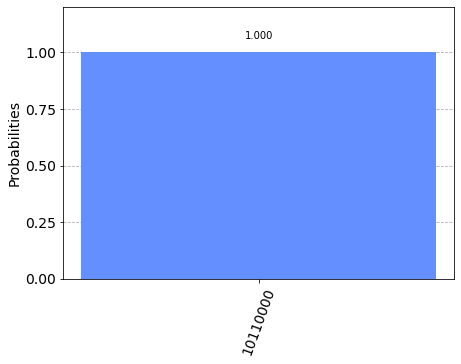

In [12]:
final_count = one_shot_result(circuit)
plot_histogram(counts)

In [13]:
r = final_count.items()
for res, shots in r:
    result = str(res)

print("the resultant measurement observed is : " + str(result))

the resultant measurement observed is : 11101101
